In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.stats as stat
#from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression


In [2]:
"""Synthetic data generation--- Final data will be availabe in X_train and Y_train"""
X_plus = [0,0,0,0]
X_minus = [0,0,0,0]
Y_plus = [0,0,0,0]
Y_minus = [0,0,0,0]
size = 150
for i in range(4):
    X_plus[i] = np.random.multivariate_normal(np.array([1,1]), np.array([[1,0],[0,1]]), size//2)   
    X_minus[i] = np.random.multivariate_normal(np.array([-1,1]), np.array([[1,0],[0,1]]), size//2)
    Y_plus[i] = np.full((size//2),1)
    Y_minus[i] = np.full((size//2),0) 

X_train = [0,0,0,0]
Y_train = [0,0,0,0]
for i in range(4):
    X_train[i] = np.concatenate((X_plus[i],X_minus[i]),axis = 0)
    Y_train[i] = np.concatenate((Y_plus[i],Y_minus[i]),axis =0)
    
#Finally four datasets are created 
#X_train[i],Y_train[i]---- i varies from 1 to 4
#These represent the data before distortion

In [3]:
print(X_train[0].shape)
print(Y_train[0].shape)

(150, 2)
(150,)


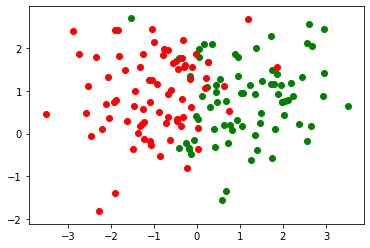

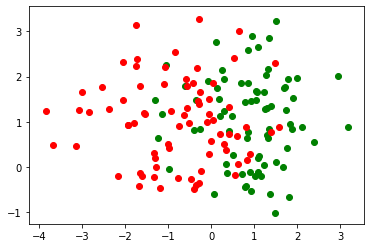

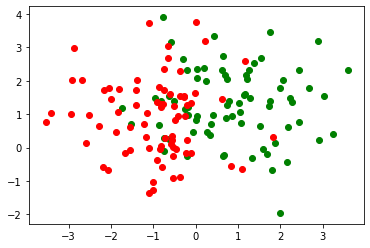

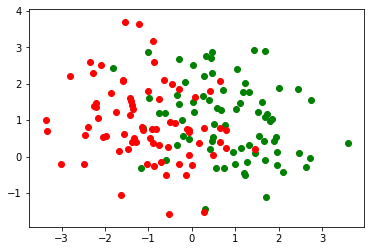

In [4]:
"""Plotting synthetic data generated"""
for i in range(4):
    X_plus_plot = X_plus[i].T
    X_minus_plot = X_minus[i].T
    plt.scatter(X_plus_plot[0],X_plus_plot[1],color = 'g')
    plt.scatter(X_minus_plot[0],X_minus_plot[1],color = 'r')
    plt.show()
    #X_plus_plot.shape
    


In [5]:
def sample_mean(A,length):
    """Function that returns sample mean of the given data"""
    return (np.sum(A,axis=0))/length

def sample_covariance(A, length, mu):
    """Function that returns sample covariance of the given data"""
    cov = np.array([[0,0],[0,0]])
    for x in A:
        y = np.array([x-mu])
        cov = cov + np.matmul(np.transpose(y),y)
        #print(cov)
    cov = cov/length
    return cov
def calc_posterior(x,mu_plus,cov_plus,mu_minus,cov_minus,prior):
    """ Function that calculates P(Y = +1|X) by using bayes formula"""
    plus_prob = stat.multivariate_normal.pdf(x,mu_plus,cov_plus)
    minus_prob = stat.multivariate_normal.pdf(x,mu_minus,cov_minus)
    val = (prior*plus_prob)/((prior*plus_prob)+((1-prior)*minus_prob))
    return val

In [6]:
def calculate_eta(X_train,Y_train):
    '''Function that finds P(1|X=x) for all training samples, so that later we can apply distortion later'''
    X_plus = [0,0,0,0]
    X_minus = [0,0,0,0]
    mu_hat_plus = [0,0,0,0]
    mu_hat_minus = [0,0,0,0]
    cov_hat_plus = [0,0,0,0]
    cov_hat_minus = [0,0,0,0]
    prior = [0,0,0,0]
    eta = [0,0,0,0]   # this list contains eta of all the data sets
    Y_pred = [0,0,0,0]
    for p in range(4):
        X_plus_temp = []
        X_minus_temp = []

        for i in range(int(X_train[p].shape[0])):
            if(Y_train[p][i] == 1):
                X_plus_temp.append(X_train[p][i])
            else:
                X_minus_temp.append(X_train[p][i])
        X_plus[p] = np.array(X_plus_temp)
        X_minus[p] = np.array(X_minus_temp)

        mu_hat_plus[p] = sample_mean(X_plus[p],X_plus[p].shape[0])
        mu_hat_minus[p] = sample_mean(X_minus[p],X_minus[p].shape[0])
        cov_hat_plus[p] = sample_covariance(X_plus[p],X_plus[p].shape[0],mu_hat_plus[p])
        cov_hat_minus[p] = sample_covariance(X_minus[p],X_minus[p].shape[0],mu_hat_minus[p] )

        len_plus = X_plus[p].shape[0]
        len_minus= X_minus[p].shape[0]
        prior[p] = len_plus /(len_plus + len_minus)
        eta_temp = []
        for i in range(X_train[p].shape[0]):
            eta_temp.append(calc_posterior(X_train[p][i],mu_hat_plus[p],cov_hat_plus[p],mu_hat_minus[p],cov_hat_minus[p],prior[p]))
        eta[p] = np.array(eta_temp)
        Y_pred_temp = []
        for i in range(X_train[p].shape[0]):
            Y_pred_temp.append(np.sign(eta[p][i]-0.5))
        Y_pred[p] = np.array(Y_pred_temp)
        #print(accuracy_score(Y_train[p],Y_pred[p]))
    return eta

In [7]:

def distort_eta(eta_original):
    eta_list = []
    eta_list.append(eta_original[0])       #correct labeller ---> no distortion caused
    eta_list.append(0.7*eta_original[1] + 0.1)  # linear distortion
    eta_list.append(0.5*stat.beta.cdf(eta_original[2],100,200) + 0.5*stat.beta.cdf(eta_original[2],200,100))   #aggressive labeller
    eta_list.append(0.5*stat.beta.cdf(eta_original[3],0.1,0.2) + 0.5*stat.beta.cdf(eta_original[3],0.2,0.1))  # distortion based on alpha = 0.5 and beta = 0.5
    return eta_list


def calculate_distorted_labels(eta_list):
    Y_distort = []
    for i in range(4):
        lis = []
        for p in eta_list[i]:
            res = (np.random.binomial(1,p,1) )
            if(res == 0): res = 0
            lis.append(res)
        lis = np.array(lis)
        Y_distort.append(lis)
    return Y_distort

In [8]:

eta_original = calculate_eta(X_train,Y_train)
eta_list = distort_eta(eta_original)
print(eta_original[0].size)
print(eta_list[0].size)
X_test_d = [0,0,0,0]
Y_test_d = [0,0,0,0]
X_train_d = [0,0,0,0]
Y_train_d = [0,0,0,0]
Y_test_d = [0,0,0,0]
Y_d = calculate_distorted_labels(eta_list)
trainsize = 100
testsize = 50
for i in range(4):
    X_train_d[i] = np.concatenate((X_train[i][:trainsize//2], X_train[i][trainsize//2+testsize//2:trainsize+testsize//2]),axis = 0)
    X_test_d[i] = np.concatenate((X_train[i][trainsize//2:trainsize//2+testsize//2], X_train[i][trainsize+testsize//2:trainsize+testsize]),axis = 0)
    Y_train_d[i] = np.concatenate((Y_d[i][:trainsize//2], Y_d[i][trainsize//2+testsize//2:trainsize+testsize//2]),axis = 0)
    Y_test_d[i] = np.concatenate((Y_d[i][trainsize//2:trainsize//2+testsize//2], Y_d[i][trainsize+testsize//2:trainsize+testsize]),axis = 0)
    print(X_train_d[i].shape, Y_train_d[i].shape,X_test_d[i].shape, Y_test_d[i].shape)
    
#Final distorted data is availabe as follows
#X_train_d[i],Y_train_d[i],X_test_d[i], Y_test_d[i]---- i varies from 1 to 4


150
150
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)


In [9]:
X_train_distort_plus = []
X_train_distort_minus = []
X_test_distort_plus = []
X_test_distort_minus = []
for i in range(4):
    lisplus = []
    lisminus = []
    j = 0
    for y in Y_train_d[i]:
        if(y == 1):
            lisplus.append(X_train_d[i][j])
        else:
            lisminus.append(X_train_d[i][j])
        j = j + 1
    lisplus = np.array(lisplus)
    lisminus = np.array(lisminus)
    X_train_distort_plus.append(lisplus)
    X_train_distort_minus.append(lisminus)
''''for i in range(4):
    lisplus = []
    lisminus = []
    j = 0
    for y in Y_test_d[i]:
        if(y == 1):
            lisplus.append(X_test_d[i][j])
        else:
            lisminus.append(X_test_d[i][j])
        j = j + 1
    lisplus = np.array(lisplus)
    lisminus = np.array(lisminus)
    X_test_distort_plus.append(lisplus)
    X_test_distort_minus.append(lisminus)'''
    


   


"'for i in range(4):\n    lisplus = []\n    lisminus = []\n    j = 0\n    for y in Y_test_d[i]:\n        if(y == 1):\n            lisplus.append(X_test_d[i][j])\n        else:\n            lisminus.append(X_test_d[i][j])\n        j = j + 1\n    lisplus = np.array(lisplus)\n    lisminus = np.array(lisminus)\n    X_test_distort_plus.append(lisplus)\n    X_test_distort_minus.append(lisminus)"

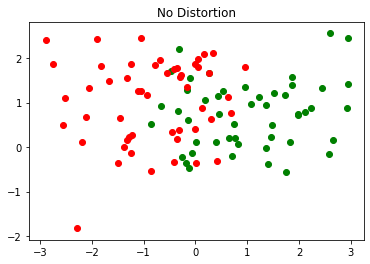

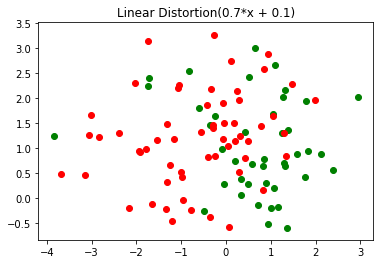

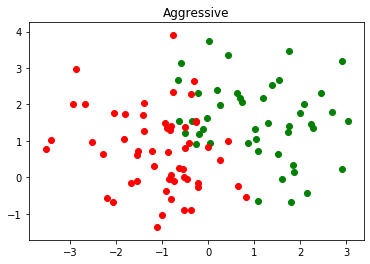

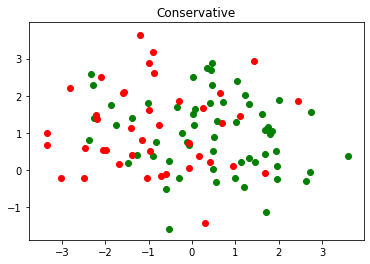

In [10]:
titles = ['No Distortion', 'Linear Distortion(0.7*x + 0.1)', 'Aggressive', 'Conservative']
for i in range(4):
    plt.title(titles[i])
    plt.scatter(X_train_distort_plus[i].T[0],X_train_distort_plus[i].T[1],color = 'g')
    plt.scatter(X_train_distort_minus[i].T[0],X_train_distort_minus[i].T[1],color = 'r')
    plt.show()
     #plt.scatter(X_test_distort_plus[i].T[0],X_test_distort_plus[i].T[1],color = 'g')
    #plt.scatter(X_test_distort_minus[i].T[0],X_test_distort_minus[i].T[1],color = 'r')
    #plt.show()

In [53]:
def accuracy_score(Y, Y_pred):
    """Function to calculate loss (Y_test[i] - Y_pred[i])**2
       Y : 0 or 1 (labels)
       Y_pred: 0 to 1(probablities)"""
    loss = 0.0
    for i in range(Y.shape[0]):
        #print((Y[i] - Y_pred[i])**2)
        loss = loss + ((Y[i] - Y_pred[i])**2)
        
        
    #print(Y.shape[0])
    return loss/(Y.shape[0])
        

In [54]:
#Baseline-1 -- separate Logistic Regression for all labellers
w_list = []
accuracy_list = []
for i in range(4):
    Y_train_d[i] =Y_train_d[i].astype('int')
    Y_test_d[i] =Y_test_d[i].astype('int')
    clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])  #training 
    Y_pred = clf.predict_proba(X_test_d[i])[:,1]    # predicting eta(x) = P(1|x) for training samples
    w_list.append(clf)
    #print(Y_pred)
    #print(Y_test_d[i])
    #print(Y_pred)
    accuracy_list.append(accuracy_score(Y_test_d[i],Y_pred))   # calculating accuracy
accuracy_list
#Y_test_distort[0].shape

[0.13107592424804826,
 0.17402559553352495,
 0.06671038483660649,
 0.1974153211829976]

In [55]:
def sort(A,A_sum,labellers):
    for i in range(labellers):
        for j in range(len(A[i])):
            min_index = j
            for k in range(j,len(A[i])):
                if(A_sum[k] < A_sum[min_index]):
                    min_index = k
            A[i][j],A[i][min_index] =  A[i][min_index],A[i][j]
                    

In [60]:
samples = 20     #no. of samples to be taken for creating the post-processing model
random_indices = np.random.choice(50,size = samples) 
#print(random_indices)
test_data = X_test_d[0][random_indices]   #take random feature vectors from test-data
#print(test_data)
A = []  #A indicates P(Y|X ) given by logistic regression for each labeller separately

# A[i][j] inidicates P(Y_ij = 1|X_j), prediction for the i_th labeller on test_data[j]
for i in range(4):
    eta = w_list[i].predict_proba(test_data)[:,1]
    A.append(eta)

A = np.array(A)
A_sum = np.sum(A,axis = 0)  
#A_sum is  a 1d array of size samples. A_sum[i] = A_sum[0][i] + A_sum[1][i] + .... + A_sum[#labellers-1][i]
sort(A,A_sum,4)
A_sum = np.sort(A_sum)
#print("-------")
#print(A_sum)
#print(A)
u = [0,0,0,0] # u is prediction after monotonic regression
for i in range(4):
    iso =  IsotonicRegression(out_of_bounds = 'clip').fit(A_sum,A[i])
    u[i] = iso.predict(A_sum)


u = np.array(u)
u.shape
print(u)


[[0.00832915 0.33483953 0.45591588 0.45591588 0.45591588 0.45591588
  0.45591588 0.45591588 0.45591588 0.45591588 0.45591588 0.45591588
  0.45591588 0.45591588 0.45591588 0.52523046 0.52523046 0.87308995
  0.87308995 0.87308995]
 [0.07261478 0.34941776 0.43992982 0.43992982 0.43992982 0.43992982
  0.43992982 0.43992982 0.43992982 0.43992982 0.43992982 0.43992982
  0.43992982 0.43992982 0.43992982 0.45965106 0.45965106 0.71014994
  0.71014994 0.71014994]
 [0.00900408 0.05598138 0.38606119 0.38606119 0.38606119 0.38606119
  0.38606119 0.38606119 0.38606119 0.38606119 0.38606119 0.38606119
  0.38606119 0.38606119 0.38606119 0.52010502 0.52010502 0.96602688
  0.96602688 0.96602688]
 [0.26708311 0.53614161 0.58549548 0.58549548 0.58549548 0.58549548
  0.58549548 0.58549548 0.58549548 0.58549548 0.58549548 0.58549548
  0.58549548 0.58549548 0.58549548 0.65315765 0.65315765 0.81342231
  0.81342231 0.81342231]]


In [61]:
def project(a,b,c):     #a is target, b and c are points on the line
    """ Projection of point 'a' on to the line joining the points 'b' and 'c' """
    v = a - b 
    #print(v)
    d = (c-b)/np.linalg.norm(c-b)
    #print(np.linalg.norm(d))
    #print(d)
    res = b + (np.dot(v,d))*d
    return res

In [62]:
post_process_loss = [0,0,0,0]
Y_prob_pred = [0,0,0,0]
eta_hat = [0,0,0,0]    #logistic regression prediction for all the labellers
for i in range(4):
    eta_hat[i] = w_list[i].predict_proba(X_test_d[i])[:,1]
eta_hat = np.array(eta_hat)
print(eta_hat)
print("_____________")
for i in range(4):   # for each labeller
    temp_prob = []
    for j in range(len(X_test_d[i])): 
        distance = float("inf")
        projection = None
        for k in range(samples-1):
            if(np.array_equal(u[:,k],u[:,k+1])):
                continue
            current_projection = project(eta_hat[:,j],u[:,k],u[:,k+1])  
            #projection of eta_hat of current test vector on to the line joining points u[k] an u[k+1]
            if(np.linalg.norm(current_projection - eta_hat[:,j]) <= distance): 
                distance = np.linalg.norm(current_projection - eta_hat[:,j])
                projection = current_projection     
        temp_prob.append(projection[i])
        
    Y_prob_pred[i] = np.array(temp_prob)
    post_process_loss[i] = accuracy_score(Y_test_d[i],Y_prob_pred[i])
    
print(Y_prob_pred)  
print("____________________")
print(post_process_loss)
    
        
        

[[9.06747127e-01 9.80414864e-01 9.44594316e-01 8.88384685e-01
  6.38967723e-01 9.58579477e-01 9.30538228e-01 7.02729737e-01
  8.35275879e-01 9.05450743e-01 9.97928435e-01 5.48952490e-01
  9.74734931e-01 9.71945796e-01 8.36222797e-01 9.87788914e-01
  5.46198078e-01 9.71127414e-01 9.59386191e-01 8.92483344e-01
  8.58803427e-01 5.39749295e-01 9.48899805e-01 2.02006075e-02
  9.75741707e-01 6.39035328e-02 1.08569642e-01 9.53291894e-02
  6.03353723e-02 1.81454036e-01 8.32915270e-03 2.58758574e-01
  1.20105974e-01 3.00548864e-02 3.34839530e-01 6.00010653e-01
  2.17029893e-01 1.98894124e-01 3.16375175e-02 7.15621389e-01
  4.97816389e-01 2.25547439e-03 1.82502866e-02 2.13707410e-01
  1.41265675e-02 2.61650385e-01 1.02217708e-01 6.66202673e-02
  3.02540702e-02 3.45215016e-01]
 [8.04179686e-01 7.86731674e-01 6.86372920e-01 5.85107686e-01
  6.08509899e-01 7.24187194e-01 6.06899423e-01 6.66699140e-01
  7.18522014e-01 7.63983151e-01 5.59054577e-01 7.61453920e-01
  9.19037829e-01 5.14178832e-01 8.320

In [59]:
iso = IsotonicRegression(out_of_bounds = 'clip').fit(np.array([1,2,3,4,5]),np.array([10,20,30,40,50])) 
iso.predict(np.array([10,20,30,40,50]))

array([50., 50., 50., 50., 50.])

In [37]:
A = np.array([[0,0.2,0.4,0.6,1],[0,0.2,0.8,0.4,1]])
A_sum = np.sum(A,axis = 0)  
#A_sum is  a 1d array of size samples. A_sum[i] = A_sum[0][i] + A_sum[1][i] + .... + A_sum[#labellers-1][i]
print(A)
sort(A,A_sum,2)
#print(A_sum)
print(A)
u = [0,0,0,0] # u is prediction after monotonic regression
for i in range(2):
    iso =  IsotonicRegression(out_of_bounds = 'clip').fit(np.array([1,2,3,4,5]),A[i])
    u[i] = iso.predict(np.array([1,2,3,4,5]))


u = np.array(u)
u.shape
print(u)


[[0.  0.2 0.4 0.6 1. ]
 [0.  0.2 0.8 0.4 1. ]]
[[0.  0.2 0.6 0.4 1. ]
 [0.  0.2 0.4 0.8 1. ]]
[array([0. , 0.2, 0.5, 0.5, 1. ]) array([0. , 0.2, 0.4, 0.8, 1. ]) 0 0]
